In [ ]:
COLAB, KAGGLE = 1, 0
COLAB_LOADED = False
IS_DOWNLOADED = False
NGROK_IS_DOWNLOADED = False



In [ ]:
if not IS_DOWNLOADED:
    if COLAB:
        from google.colab import drive
        drive.mount('/content/drive')
    #!pip3 install tensorflow
    #!pip3 install tensorboard
    !pip3 install tensorboardx
    
    #!pip3 install gin-config==0.1.4
    !wget ftp://171.64.64.64/cs/cvgl/Stanford_Online_Products.zip
    IS_DOWNLOADED = True

if not NGROK_IS_DOWNLOADED and KAGGLE:
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    !./ngrok authtoken 1c7d7L4ji4a6fzH7ajxpJcn5yhi_4WwPeiNEFFSG5MghJow7Q
    NGROK_IS_DOWNLOADED = True

Mounted at /content/drive
     |████████████████████████████████| 317kB 13.4MB/s 
--2020-12-11 07:40:10--  ftp://171.64.64.64/cs/cvgl/Stanford_Online_Products.zip
           => ‘Stanford_Online_Products.zip’
Connecting to 171.64.64.64:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /cs/cvgl ... done.
==> SIZE Stanford_Online_Products.zip ... 3083860082
==> PASV ... done.    ==> RETR Stanford_Online_Products.zip ... done.
Length: 3083860082 (2.9G) (unauthoritative)

Stanford_Online_Pro 100%[===================>]   2.87G  16.7MB/s    in 3m 1s   

2020-12-11 07:43:13 (16.3 MB/s) - ‘Stanford_Online_Products.zip’ saved [3083860082]



In [ ]:

import datetime, os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import pickle
import cv2
from io import BytesIO
from PIL import Image
import zipfile
import gc
import math, os
from random import shuffle
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter



In [ ]:
#https://medium.com/@iamsdt/using-tensorboard-in-google-colab-with-pytorch-458f9bb95212



    #!curl -s http://localhost:4040/api/tunnels

In [ ]:

RESNET_D = True
RESNET_C = True
RESNET_B = True
BN_ZERO_GAMMA = True
CLASS_COUNT = 12


def MyConv(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False, zero_bn_gamma=False, conv_accum=None):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,bias=bias)
    torch.nn.init.xavier_uniform_(conv.weight)
    if bias:
        torch.nn.init.zeros_(conv.bias)
    if conv_accum is not None:
        conv_accum.append(conv.weight)
    bn = nn.BatchNorm2d(out_channels, affine=True, track_running_stats=False)
    if BN_ZERO_GAMMA and zero_bn_gamma:
        torch.nn.init.zeros_(bn.weight)
    return nn.Sequential(conv, bn)


class ResNetBlockBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, is_downsample=False, conv_accum=None):
        super(ResNetBlockBottleneck, self).__init__()
        assert out_channels % 4 == 0
        self.in_channels = in_channels
        self.out_channels = out_channels
        internal_channels = out_channels // 4
        self.shortcut_is_needed = in_channels == out_channels
        if is_downsample:
            stride = 2
            if RESNET_D:
                self.shortcut = nn.Sequential(
                    nn.AvgPool2d((2, 2), stride=(stride, stride), padding=(0, 0)),
                    MyConv(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0),
                              bias=False, zero_bn_gamma=False, conv_accum=conv_accum)
                )
            else:
                self.shortcut = MyConv(in_channels, out_channels, kernel_size=(1, 1), stride=(stride, stride), padding=(0, 0),
                              bias=False, zero_bn_gamma=False, conv_accum=conv_accum)
                
        else:
            stride = 1
            if in_channels==out_channels:
                self.shortcut = nn.Identity()
            else:
                self.shortcut = MyConv(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0),
                         bias=False, zero_bn_gamma=False, conv_accum=conv_accum)

        if RESNET_B:
            self.block = nn.Sequential(
                MyConv(in_channels, internal_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False, conv_accum=conv_accum),
                nn.ReLU(),
                MyConv(internal_channels, internal_channels, kernel_size=(3, 3), stride=(stride, stride), padding=(1, 1),
                          bias=False, conv_accum=conv_accum),
                nn.ReLU(),
                MyConv(internal_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False, zero_bn_gamma=True, conv_accum=conv_accum)
            )
        else:
            self.block = nn.Sequential(
                MyConv(in_channels, internal_channels, kernel_size=(1, 1), stride=(stride, stride), padding=(0, 0), bias=False, conv_accum=conv_accum),
                nn.ReLU(),
                MyConv(internal_channels, internal_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),
                          bias=False, conv_accum=conv_accum),
                nn.ReLU(),
                MyConv(internal_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False, zero_bn_gamma=True, conv_accum=conv_accum)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        #print(x.shape)
        return self.relu(self.block(x) + self.shortcut(x))


class ResNet(nn.Module):
    def __init__(self, class_count):
        super(ResNet, self).__init__()
        self.conv_weights = []
        if RESNET_C:
            layers = [MyConv(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), conv_accum=self.conv_weights), 
                      nn.ReLU(),
                      MyConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), conv_accum=self.conv_weights),
                      nn.ReLU(),
                      MyConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), conv_accum=self.conv_weights),
                      nn.ReLU(),
                      nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1))]
        else:
            layers = [MyConv(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), conv_accum=self.conv_weights),
                      nn.ReLU(),
                      nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1))] 
        layers += [ResNetBlockBottleneck(64, 256, is_downsample=False, conv_accum=self.conv_weights)] 
        layers += [ResNetBlockBottleneck(256, 256, is_downsample=False, conv_accum=self.conv_weights) for _ in range(2)] 
        layers += [ResNetBlockBottleneck(256, 512, is_downsample=True, conv_accum=self.conv_weights)] 
        layers += [ResNetBlockBottleneck(512, 512, is_downsample=False, conv_accum=self.conv_weights) for _ in range(3)]
        layers += [ResNetBlockBottleneck(512, 1024, is_downsample=True, conv_accum=self.conv_weights)] 
        layers += [ResNetBlockBottleneck(1024, 1024, is_downsample=False, conv_accum=self.conv_weights) for _ in range(5)] 
        layers += [ResNetBlockBottleneck(1024, 2048, is_downsample=True, conv_accum=self.conv_weights)]  
        layers += [ResNetBlockBottleneck(2048, 2048, is_downsample=False, conv_accum=self.conv_weights) for _ in range(2)] 
        layers += [nn.AvgPool2d((7, 7))]
        self.layers = nn.Sequential(
            *layers
        )
        self.decoder = nn.Linear(2048, class_count, bias=True)
        torch.nn.init.xavier_uniform_(self.decoder.weight)
        torch.nn.init.zeros_(self.decoder.bias)
        print(f"layer_count {len(self.conv_weights)}")

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        return self.decoder(x)

dummy = torch.ones((1, 3, 224, 224))


loss_fn = nn.CrossEntropyLoss()
CUDA = torch.cuda.device_count()
device = 'cuda'
if True:
    model = ResNet(class_count=CLASS_COUNT)
    #print(model)
    print(model(dummy).shape)

layer_count 55
torch.Size([1, 12])


In [ ]:
if CUDA:
  print(torch.cuda.get_device_name(0))
  print(torch.cuda.memory_summary(device=0))
  print(torch.cuda.max_memory_allocated(device=0))
  

Tesla P100-PCIE-16GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |     

In [ ]:
if 0:
    print("Reading zip file into memory...",end="")
    with open('Stanford_Online_Products.zip',"rb") as f:
        zip_file_in_mem = f.read()
    print("OK")
    file_like_object = BytesIO(zip_file_in_mem)
    sopzip = zipfile.ZipFile(file_like_object,"r")
else:
    sopzip = zipfile.ZipFile('Stanford_Online_Products.zip',"r")
    #sopzip = zipfile.ZipFile('/content/drive/My Drive/datasets/test.zip',"r")


In [ ]:


#SOP_DEFINITION = "/content/drive/My Drive/datasets/SOP_train_valid_split.pickle"
SOP_DEFINITION = "/content/drive/My Drive/datasets/SOP_train_valid_test_split.pickle"

class SOP_classification(Dataset):
    def __init__(self, type='train', _transforms=None, size=None):
        assert type in ['test', 'train', 'valid']
        self.type = type
        self.transforms = _transforms
        self.samples = []
        self.labels = []
        self.toPIL = torchvision.transforms.ToPILImage()
        self.toTensor = torchvision.transforms.ToTensor()
        with open(SOP_DEFINITION, 'rb') as f:
            sop_dict = pickle.load(f)
        self.classes_names = list(sop_dict.keys())
        self.class_labels = []
        '''
            >>> data['bicycle_final']['train'].keys()
            dict_keys(['paths', 'product_labels', 'category_labels'])
        '''
        self.nrof_classes = len(self.classes_names)
        
        edge = 1500 if type=="train" else 300
        if True:
            for class_index, _class in enumerate(self.classes_names):
                print(f"\nhandling class {_class} ({class_index}/{self.nrof_classes}):")
                self.class_labels.append(sop_dict[_class][type]['category_labels'][0])
                nrof_samples = len(sop_dict[_class][type]['paths'])
                for ind, name in enumerate(sop_dict[_class][type]['paths']):
                    
                    if type == 'test':
                      names = name.split('/')
                      #print(names)

                      name = 'test/'+names[2] + '/'+names[2] + '_' + names[3]
                      print(f"\thandling image {ind}/{nrof_samples}: {name}...", end='')
                      label = sop_dict[_class][type]['category_labels'][ind]
                      self.samples.append((name, label))
                    else:
                      print(f"\r\thandling image {ind}/{nrof_samples}: {name}...", end='')
                    
                      label = sop_dict[_class][type]['category_labels'][ind]
                      self.samples.append((name[1:], label))
        shuffle(self.samples)
        self.classes_names = list(self.classes_names)
        print(f"\nCLASSES: {self.classes_names} {self.class_labels}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        name , label = self.samples[index]
        try:
            filedata = sopzip.read(name)
            dataEnc = BytesIO(filedata)
            sample = Image.open(dataEnc).convert('RGB')
            dataEnc.close()
        except Exception:
            print("Error reading: {}".format(name))
            sample = np.zeros((3,256,256))
            sample = Image.fromarray(np.uint8(sample))
        if self.transforms:
            sample = self.transforms(sample)
        #print(sample.min(), sample.max())
        return sample, label
    

class SOP_shuffled_fixed(Dataset):
    def __init__(self, type='train', _transforms=None, size=12000):
        self.dataset = SOP_classification(type, _transforms=_transforms)
        self.orig_len = len(self.dataset)
        self.size=size
        self.indexes_map = np.arange(self.orig_len)
        np.random.shuffle(self.indexes_map)
        self.shuffle_edge = 5000
        self.count = 0        
        
    def __len__(self):
        return self.size

    def __getitem__(self, index):
        if self.count >= self.shuffle_edge:
            self.count = 0 
            np.random.shuffle(self.indexes_map)
        return self.dataset[self.indexes_map[index]]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
!rm -rf error*

In [ ]:
train_transform = transforms.Compose(
        [
            transforms.RandomResizedCrop(224,scale=(0.3, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(saturation=0.3, contrast=0.3, brightness=0.3),
            transforms.ToTensor(),
            transforms.Normalize((123.68 / 255, 116.779 / 255, 103.939/ 255), (58.393 / 255, 57.12 / 255, 57.375 / 255)),
            #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ]
    )

test_transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((123.68 / 255, 116.779 / 255, 103.939/ 255), (58.393 / 255, 57.12 / 255, 57.375/255)),
            #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ]
    )
if 1:
    trainset = SOP_classification('train', _transforms=train_transform)
    validset = SOP_classification('valid', _transforms=test_transform)
    testset = SOP_classification('test', _transforms=test_transform)
else:
    trainset = SOP_shuffled_fixed('train', _transforms=train_transform, size=24000)
    testset = SOP_shuffled_fixed('valid', _transforms=test_transform, size=6000)

#print(len(trainset))
#[trainset[i] for i in range(len(trainset)-1,50000,-1)]


handling class cabinet_final (0/12):
	handling image 7228/7229: /Stanford_Online_Products/cabinet_final/261464973407_0.JPG...
handling class bicycle_final (1/12):
	handling image 4977/4978: /Stanford_Online_Products/bicycle_final/231493409797_1.JPG...
handling class chair_final (2/12):
	handling image 7237/7238: /Stanford_Online_Products/chair_final/161407030983_2.JPG...
handling class sofa_final (3/12):
	handling image 4453/4454: /Stanford_Online_Products/sofa_final/261965607464_1.JPG...
handling class mug_final (4/12):
	handling image 8164/8165: /Stanford_Online_Products/mug_final/261973644335_6.JPG...
handling class stapler_final (5/12):
	handling image 998/5023: /Stanford_Online_Products/stapler_final/251996582027_3.JPG...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	handling image 5814/5815: /Stanford_Online_Products/coffee_maker_final/311413817362_5.JPG...
handling class table_final (8/12):
	handling image 6658/6659: /Stanford_Online_Products/table_final/171261687946_2.JPG...
handling class fan_final (9/12):
	handling image 3586/3587: /Stanford_Online_Products/fan_final/371375925121_11.JPG...
handling class lamp_final (10/12):
	handling image 7512/7513: /Stanford_Online_Products/lamp_final/252048612402_0.JPG...
handling class kettle_final (11/12):
	handling image 6062/6063: /Stanford_Online_Products/kettle_final/271526193068_9.JPG...
CLASSES: ['cabinet_final', 'bicycle_final', 'chair_final', 'sofa_final', 'mug_final', 'stapler_final', 'toaster_final', 'coffee_maker_final', 'table_final', 'fan_final', 'lamp_final', 'kettle_final'] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

handling class cabinet_final (0/12):
	handling image 2419/2420: /Stanford_Online_Products/cabinet_final/400882278599_0.JPG...
handling class bicycle_final (1/12):
	handling image 

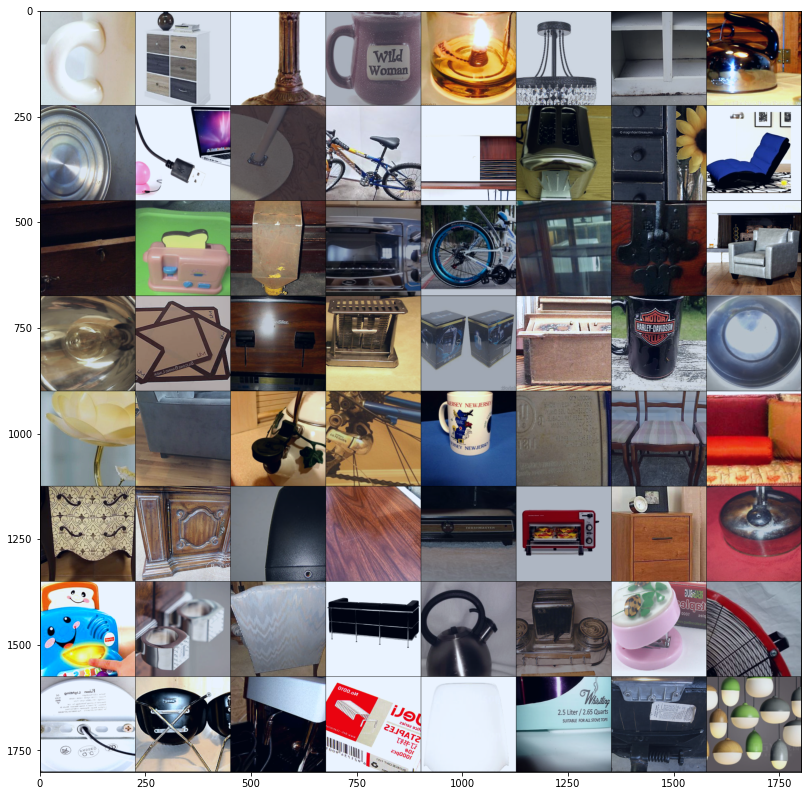

In [ ]:

def prin_batch():
    BS = 64
    TRAIN=1
    if TRAIN:
        test_loader = DataLoader(trainset, batch_size=BS, shuffle=True)
    else:
        test_loader = DataLoader(testset, batch_size=BS, shuffle=True)
    #train_loader = DataLoader(trainset, batch_size=BS, shuffle=True)
    
    epochs = 0
    epoch = 0
    images, labels = iter(test_loader).next()
    #print(images.shape, labels.shape)
    
    img = images.data 
    #print(img.min(), img.max())
    img = img - img.min()
    img = img / img.max()
    img = make_grid(img, nrow=8, padding=1).numpy()
    #print(img.shape, img.dtype, img.max(), img.min())
    img = np.rollaxis(img, 0, 3)

    plt.figure(figsize=(14, 14)), plt.imshow(img), plt.show()
    if False:
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,0]), plt.show()
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,1]), plt.show()
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,2]), plt.show()
prin_batch()

In [ ]:
def one_batch():
    gc.collect()
    mean_train_losses = []
    mean_test_losses = []
    test_acc_list = []
    model = ResNet(class_count=CLASS_COUNT)
    BS = 64
    test_loader = DataLoader(testset, batch_size=BS, shuffle=False)
    #train_loader = DataLoader(trainset, batch_size=BS, shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
    epochs = 0
    epoch = 0
    images, labels = iter(test_loader).next()
    print(images.shape, labels.shape)
    

    if CUDA:
        images = images.to(device)
        labels = labels.to(device)

        model.to(device)

    accuracy = 0
    while accuracy < 100:
        epoch += 1
        model.train()

        train_losses = []
        test_losses = []

        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        correct = 0
        total = 0

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        mean_train_losses.append(np.mean(train_losses))

        accuracy = 100 * correct / total
        test_acc_list.append(accuracy)
        print('epoch : {}, train loss : {:.4f}, test loss : {:.4f}, test acc : {:.2f}%' \
              .format(epoch + 1, np.mean(train_losses), np.mean(test_losses), accuracy))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax1.plot(mean_train_losses, label='train')
    # ax1.plot(mean_test_losses, label='test')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')

    ax2.plot(test_acc_list, label='test acc')
    ax2.legend()
    plt.show()



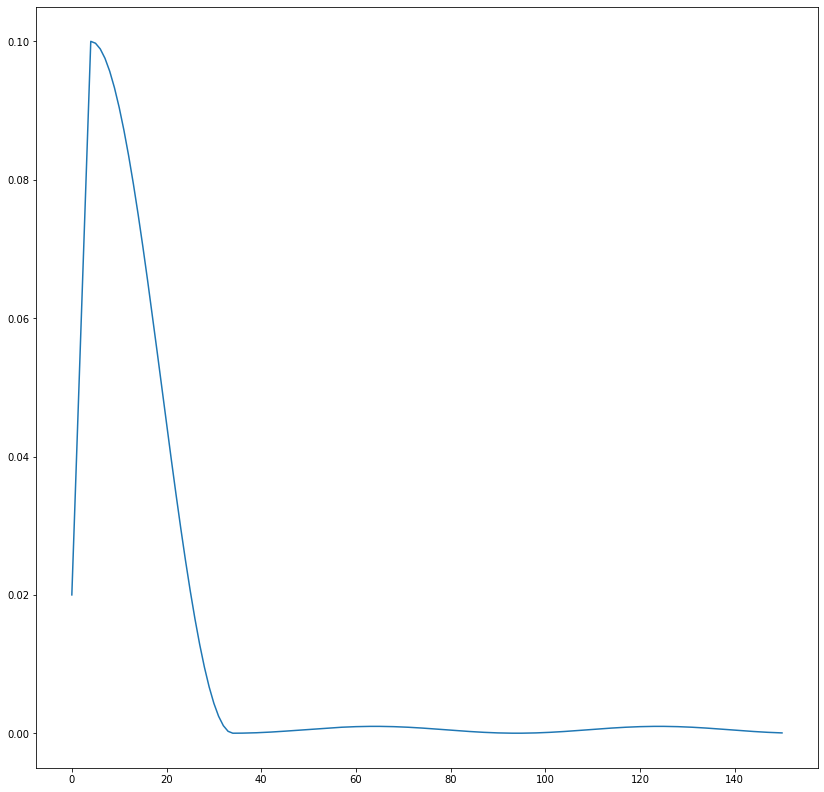

In [ ]:

def smooth_loss(pred, gold, eps = 0.1):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if eps:
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        loss = -(one_hot * log_prb).sum() / pred.size(0)
    else:
        loss = F.cross_entropy(pred, gold)
    return loss


class MyWarmupCosineAnnealingLR(torch.optim.lr_scheduler._LRScheduler):
    r"""
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        linear_lr_m (int): линейная часть
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, linear_lr_m, T_max, eta_min=0, sin_max=0.01,last_epoch=-1):
        self.linear_lr_m = linear_lr_m
        self.T_max = T_max
        self.eta_min = eta_min
        self.sin_max = sin_max
        super(MyWarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        ''' копипаста cosine lr
        выдать список новых lr. base_lrs = [gr['init_lr'] for rg in opt.groups]'''
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if self.last_epoch == 0:
            return [lr / self.linear_lr_m for lr in self.base_lrs] # initial lrs
        elif self.last_epoch <self.linear_lr_m:
            return [ (self.last_epoch + 1) * lr / self.linear_lr_m for lr in self.base_lrs]
        elif (self.last_epoch - self.linear_lr_m  - self.T_max) % (2 * self.T_max) == 0:
            return [group['lr'] + (self.sin_max - self.eta_min) *
                    (1 - math.cos(math.pi / self.T_max)) / 2
                    for base_lr, group in
                    zip(self.base_lrs, self.optimizer.param_groups)]
        return [(1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m +1) / self.T_max)) /
                (1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m ) / self.T_max)) *
                (group['lr'] - self.eta_min) + self.eta_min
                for group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m) / self.T_max)) / 2
                for base_lr in self.base_lrs]


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def test_lr():
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0, nesterov=True)
  linear_lr_m = 5
  T_max = 30
  eta_min = 0.00001
  SIN_MAX = 0.001
  sched =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)
  lrs = [get_lr(optimizer)]
  optimizer.step()
  sched.step()
  for i in range(150):
      lrs.append(get_lr(optimizer)), optimizer.step(), sched.step()
  plt.figure(figsize=(14, 14))
  plt.plot(lrs)
  plt.show()

test_lr()

In [ ]:
NGROK_IS_DOWNLOADED = False
if not os.path.exists('ngrok'):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    !./ngrok authtoken 1kHcI0NiZjcxHDqui6dzTXpIL4U_4JWzssQkKjZvGjJTsrPA1
    NGROK_IS_DOWNLOADED = True
!pip2 install google-auth-oauthlib==0.4.1 grpcio==1.24.3
get_ipython().system_raw('tensorboard --logdir "/content/drive/My Drive/datasets/runs" --host 0.0.0.0 --port 1337 & ')
get_ipython().system_raw('./ngrok http 1337 &')
print("succes")

--2020-12-05 13:39:09--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.224.51.10, 52.44.17.83, 54.160.18.204, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.224.51.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.0MB/s    in 0.9s    

2020-12-05 13:39:10 (14.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
     |████████████████████████████████| 2.2MB 15.6MB/s 
ERROR: tensorflow 2.1.0 has requirement tensorflow-estimator<2.2.0,>=2.1.0rc0, but you'll have tensorflow-estimator 1.15.0 which is incompatible.
  Found existing installation: google-auth-oauthlib 0.4.0
    Uninstalling google-aut

In [ ]:
#del model
#del batch
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Thu Dec  3 17:04:52 2020
Driver Version                            : 418.67
CUDA Version                              : 10.1

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla P100-PCIE-16GB
    Product Brand                         : Tesla
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : Function Not Found
        Pending                           : Function Not Found
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 0320118080822
    GPU UUID                          

In [ ]:
BS = 64
LR = 0.1 * BS / 256
WD = 0.00001
MOMENTUM = 0.9
LS_EPS = 0.1
linear_lr_m = 5 # количество эпох для линейного увеличения
T_max = 30 
eta_min = 0.000001
SIN_MAX = LR
SAVE_MODEL = True
PATH = "/content/drive/My Drive/models/resne50_advanced"
if False and COLAB:
    #get_ipython().system_raw('tensorboard --logdir ./runs --host 0.0.0.0 --port 6006 &')
    if not COLAB_LOADED:
      COLAB_LOADED=True
      %load_ext tensorboard
    %tensorboard --logdir '/content/drive/My Drive/datasets/runs' --host 0.0.0.0 --port 6006
    #get_ipython().system_raw('./ngrok http 6006 &')



#writer = SummaryWriter(logdir='./runs/{}'.format(datetime.datetime.now().strftime("%B_%d_%Y_%H_%M")))
writer = SummaryWriter(logdir='/content/drive/My Drive/datasets/runs/advanced-lr_{}_WD_{}_LS{}'.format(LR,WD,LS_EPS))
mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc = None, None, None, None, None
def train():
    global mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc
    gc.collect()
    mean_train_losses = []
    mean_test_losses = []
    test_acc_list = []
    train_acc_list = []
    balanced_test_acc = []
    model = ResNet(class_count=CLASS_COUNT)
    test_loader = DataLoader(testset, batch_size=BS, shuffle=True, num_workers=1)
    valid_loader = DataLoader(validset, batch_size=BS, shuffle=True, num_workers=1)
    train_loader = DataLoader(trainset, batch_size=BS, shuffle=True, num_workers=1)
    epochs = 50
    best_acc = 0
    # torch.save(model, PATH)
    # print(f"Model was dumped to {PATH}")

    
    # model.eval()
    print(f"layer_count: {len(model.conv_weights)}")
    print("train started")
    
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=0, nesterov=True)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4, factor=0.1, threshold=0.01 )
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10, 15], gamma=0.1)
    scheduler =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)
    
    if 1:
      model = torch.load("/content/drive/My Drive/models/resne50_advancedbs32.pt")
      epoch_start = 25
      for _ in range(epoch_start):
        optimizer.step(), scheduler.step()
    else:
      epoch_start = 0

    if CUDA:
        device = 'cuda'
        gc.collect()
        torch.cuda.empty_cache()
        model.to(device)

    for epoch in range(epoch_start, epochs):
        print(f"epoch : {epoch}")
        epoch_start_time = time.time()
        model.train()

        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        train_losses = []
        test_losses = []
        iter_count = len(train_loader)
        for i, (images, label_batch) in enumerate(train_loader):

            if CUDA:
                images = images.to(device)
                labels = label_batch.to(device)
            else:
                labels = label_batch
            
            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            np.add.at(correct, label_batch[(predicted == labels)], 1)
            np.add.at(total,label_batch,1)

            #loss = loss_fn(outputs, labels)
            loss = smooth_loss(outputs, labels, eps=LS_EPS)
            
            writer.add_scalar("TRAIN LOSS(BATCH)/loss",loss.item(), epoch*iter_count + i)

            reg_loss = (model.decoder.weight ** 2).sum()
            for param in model.conv_weights:
                reg_loss += (param ** 2).sum() 
            reg_loss = WD*reg_loss
            loss = loss + reg_loss
            
            
            
            loss.backward()
            optimizer.step()
            

            train_losses.append(loss.item())
            
            writer.add_scalar("TRAIN LOSS(BATCH)/reg_loss",reg_loss.item(), epoch*iter_count + i)
            writer.add_scalar("TRAIN LOSS(BATCH)/full_loss",loss.item(), epoch*iter_count + i)
            #writer.add_scalar("TRAIN LOSS(BATCH)/full",full_loss.item(), epoch*iter_count + i)
            
            print(f"\r\ttraining {i}/{iter_count} | curr_acc {np.round(correct / total,3)} loss: {train_losses[-1]} reg_loss{reg_loss.item()}", end="")

        t_accuracy = correct.sum() / total.sum()
        train_acc_list.append(t_accuracy)
        model.eval()
        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        print()
        iter_count = len(valid_loader)
        with torch.no_grad():
            for i, (images, label_batch) in enumerate(valid_loader):
                

                if CUDA:
                    images = images.to(device)
                    labels = label_batch.to(device)
                else:
                    labels = label_batch

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                
                
                test_losses.append(loss.item())
                #writer.add_scalar("VALID LOSS(BATCH)",loss.item(), epoch*iter_count + i)

                _, predicted = torch.max(outputs.data, 1)
                np.add.at(correct, label_batch[(predicted == labels)], 1)
                np.add.at(total,label_batch,1)
                print(f"\r\tvalidating {i}/{iter_count} | curr_acc {np.round(correct / total, 3)} test_loss: {test_losses[-1]}", end="")

        mean_train_losses.append(np.mean(train_losses))
        mean_test_losses.append(np.mean(test_losses))
        
        #scheduler.step(mean_test_losses[-1])
        scheduler.step()
        
        
        
        accuracy = correct.sum() / total.sum()
        balanced_test_acc.append(np.mean(correct / total))
        test_acc_list.append(correct.sum() / total.sum())
        
        writer.add_scalars('Total/Acc', {'valid':test_acc_list[-1] , 'train': train_acc_list[-1],'balanced':balanced_test_acc[-1]}, epoch)
        writer.add_scalars('Total/Loss', {'valid':mean_test_losses[-1] , 'train': mean_train_losses[-1]}, epoch)
        writer.add_scalar('Total/LR', get_lr(optimizer), epoch)
        
        print('\n\ttrain loss : {}, test loss : {}, train acc : {}, test acc : {}, epoch_time: {}s' \
              .format( mean_train_losses[-1], mean_test_losses[-1], np.round(t_accuracy,2), np.round(accuracy,4), int(time.time()-epoch_start_time)))
              
        if SAVE_MODEL and accuracy > best_acc:
            torch.save(model, PATH + f"bs32_3.pt") # {balanced_test_acc[-1]}
            best_acc =accuracy
            print(f"Model was dumped to {PATH}")
try:
    train()
except Exception as e:
    print(f"ERROR: {e}")
finally:
    writer.close()

layer_count 55
layer_count: 55
train started
epoch : 25
	training 1124/1125 | curr_acc [0.809 0.934 0.793 0.816 0.916 0.838 0.789 0.791 0.699 0.775 0.766 0.826] loss: 1.4071617126464844 reg_loss0.1744059920310974
	validating 375/376 | curr_acc [0.704 0.918 0.673 0.741 0.857 0.723 0.659 0.722 0.509 0.654 0.627 0.748] test_loss: 1.0840802192687988
	train loss : 1.2092254480255975, test loss : 0.9280233088325947, train acc : 0.81, test acc : 0.71, epoch_time: 884s
Model was dumped to /content/drive/My Drive/models/resne50_advanced
epoch : 26
	training 1124/1125 | curr_acc [0.814 0.936 0.793 0.815 0.918 0.837 0.78  0.804 0.702 0.774 0.773 0.815] loss: 1.8409175872802734 reg_loss0.1744059920310974
	validating 375/376 | curr_acc [0.712 0.921 0.673 0.737 0.857 0.718 0.653 0.719 0.504 0.653 0.616 0.756] test_loss: 0.9339456558227539
	train loss : 1.2083357682757907, test loss : 0.9293286925617684, train acc : 0.81, test acc : 0.71, epoch_time: 850s
epoch : 27
	training 1124/1125 | curr_acc [0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in true_divide


	validating 375/376 | curr_acc [0.709 0.91  0.678 0.739 0.857 0.723 0.654 0.715 0.502 0.654 0.616 0.749] test_loss: 1.1433112621307373
	train loss : 1.2078895480897691, test loss : 0.9287041641296224, train acc : 0.81, test acc : 0.71, epoch_time: 874s
epoch : 43


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide


	training 1124/1125 | curr_acc [0.811 0.936 0.797 0.812 0.919 0.841 0.781 0.789 0.711 0.771 0.775 0.823] loss: 1.3775267601013184 reg_loss0.1744059920310974
	validating 375/376 | curr_acc [0.711 0.91  0.676 0.735 0.862 0.72  0.647 0.718 0.503 0.652 0.617 0.751] test_loss: 0.6253204345703125
	train loss : 1.2070375006463792, test loss : 0.9298359439411061, train acc : 0.81, test acc : 0.71, epoch_time: 863s
epoch : 44
	training 1124/1125 | curr_acc [0.806 0.935 0.791 0.808 0.915 0.838 0.783 0.794 0.699 0.774 0.778 0.821] loss: 1.6200170516967773 reg_loss0.1744059920310974
	validating 375/376 | curr_acc [0.716 0.912 0.671 0.741 0.85  0.714 0.636 0.715 0.498 0.649 0.62  0.753] test_loss: 0.6256031394004822
	train loss : 1.2087382423082988, test loss : 0.9319755702893785, train acc : 0.81, test acc : 0.71, epoch_time: 860s
epoch : 45
	training 1124/1125 | curr_acc [0.809 0.933 0.796 0.815 0.916 0.836 0.784 0.797 0.699 0.77  0.775 0.819] loss: 1.764549970626831 reg_loss0.1744059920310974
	v

In [ ]:
def save_image(path_to, image, iter, label, predicted_class, conf):
    if not os.path.exists(path_to):
        os.makedirs(path_to)
    torchvision.utils.save_image(image, path_to+'iter:%d_l:%s_pr:%s_conf:%.3f.jpg'%(iter, label, predicted_class, conf),
                                 normalize=True)

def save_confident_errors(images, labels, predictions, predicted_classes, path_to, num_classes, class_names, topk=20):
    for class_id in range(num_classes):
        indices = np.arange(len(labels), dtype=np.int)[np.logical_and(np.equal(labels, class_id),
                                                                      np.logical_not(np.equal(predicted_classes,
                                                                                              class_id)))]
        class_predictions = predictions[indices, class_id]
        class_indices_conf = np.argsort(-class_predictions)[:topk]
        for i, index in enumerate(class_indices_conf):
            save_image(path_to+class_names[class_id]+'/', images[indices[index]], i, class_names[class_id],
                       class_names[predicted_classes[indices[index]]], class_predictions[index])
            
BS=64
test_losses = []
PATH = "/content/drive/My Drive/models/resne50_advancedcont.pt"
def validate():
  global test_losses
  test_loader = DataLoader(testset, batch_size=BS, shuffle=True, num_workers=1)
  model = torch.load(PATH)

  model.eval()
  correct = np.zeros(CLASS_COUNT)
  total = np.zeros(CLASS_COUNT)
  iter_count = len(test_loader)
  with torch.no_grad():
    for i, (images, label_batch) in enumerate(test_loader):
                

      if CUDA:
        images = images.to(device)
        labels = label_batch.to(device)
      else:
        labels = label_batch

      outputs = model(images)
      loss = loss_fn(outputs, labels)
                
                
                
      test_losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      np.add.at(correct, label_batch[(predicted == labels)], 1)
      np.add.at(total,label_batch,1)


      #if loss> 1.25:
      #  save_confident_errors(images.cpu(), labels.cpu(), outputs.cpu(), predicted.cpu(), "errors/", 12,testset.classes_names)
      print(f"\r\tvalidating {i}/{iter_count} | curr_acc {np.round(correct / total, 3)} test_loss: {test_losses[-1]}", end="")

    mean_test_loss = np.mean(test_losses)
    print('\n\t test loss : {}, test acc : {} acc(balanced): {}' \
              .format( mean_test_loss, correct.sum() / total.sum(), np.mean(correct / total)))

validate()

	validating 376/377 | curr_acc [0.792 0.922 0.673 0.769 0.883 0.77  0.67  0.79  0.553 0.746 0.726 0.831] test_loss: 0.21899747848510742
	 test loss : 0.8311192759310219, test acc : 0.759390061492438 acc(balanced): 0.7603772860094993


In [ ]:

adversarial_transform = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ]
    )
normalize = transforms.Normalize((123.68 / 255, 116.779 / 255, 103.939 / 255), 
                                 (58.393 / 255, 57.12 / 255, 57.375 / 255))

def denormalize(x):
  std = torch.tensor((58.393 / 255, 57.12 / 255, 57.375 / 255)).view(-1,1,1)
  mean = torch.tensor((123.68 / 255, 116.779 / 255, 103.939 / 255)).view(-1,1,1)
  if CUDA:
    std = std.cuda()
    mean= mean.cuda()
  return x.mul_(std).add_(mean)

def print_batch(batch):
    img = make_grid(batch, nrow=4, padding=1).detach().cpu().numpy()
    #print(img.shape, img.dtype, img.max(), img.min())
    img = np.rollaxis(img, 0, 3)

    plt.figure(figsize=(100,100)) 
    plt.imshow(img)
    plt.show()

FROM_ARCHIVE = True

class SOP_adversarial(Dataset):
    def __init__(self):
        self.samples = []
        self.labels = []
        if not os.access("filenames.txt", os.F_OK):
          !wget https://raw.githubusercontent.com/IuliiaSaveleva/Advanced_Computer_Vision_course_students/master/AdversarialExamples/filenames.txt
        self.toTensor = torchvision.transforms.ToTensor()
        with open(SOP_DEFINITION, 'rb') as f:
            sop_dict = pickle.load(f)
        self.classes_names = list(sop_dict.keys())

        with open("filenames.txt", 'r') as f:
            files = f.read().splitlines()
        # "/Stanford_Online_Products/"   
        self.nrof_classes = len(self.classes_names)
        
        self.classes_names = trainset.classes_names
        self.class_labels = trainset.class_labels

        for filename in files:
          
          # bicycle_final/111588452395_0.JPG
          if FROM_ARCHIVE:
            self.samples.append("Stanford_Online_Products/"  +filename)
          else:
            f = filename.split('/')[-1]
            self.samples.append("modified/"  +f)
          self.labels.append(self.class_labels[self.classes_names.index(filename.split('/')[0])])
          print(self.samples[-1], self.labels[-1])
        

        print(f"\nCLASSES: {self.classes_names} {self.class_labels}")

    def __len__(self):
        return len(self.samples)
    
    def get_filename_by_index(self, index):
        return self.samples[index]

    def __getitem__(self, index):
        name = self.samples[index]
        label = self.labels[index]
        if FROM_ARCHIVE:
          try:
              filedata = sopzip.read(name)
              dataEnc = BytesIO(filedata)
              sample = Image.open(dataEnc).convert('RGB')
              dataEnc.close()
          except Exception:
              print("Error reading: {}".format(name))
              sample = np.zeros((3,256,256))
              sample = Image.fromarray(np.uint8(sample))
        else:
            sample = Image.open(name).convert('RGB')
        
        sample = adversarial_transform(sample)
        #print(sample.min(), sample.max())

        return sample, label, index


ad_dataset = SOP_adversarial()

def save_images(batch, indices):
  path_to = "modified/"
  if not os.path.exists(path_to):
      os.makedirs(path_to)
  for image, ind in zip(batch, indices):
      filename = ad_dataset.get_filename_by_index(ind).split('/')[-1]
      torchvision.utils.save_image(image, path_to+filename,
                                  normalize=False)
  !7z a mod_images.7z modified


def adversarial_examples():
  
  
  # check
  bs = len(ad_dataset)
  for i in range(bs):
    ad_dataset[i]
  print(f"Example_count={bs}")
  ad_loader = DataLoader(ad_dataset, batch_size=bs, shuffle=True)
  images, labels, indices = iter(ad_loader).next()
  if CUDA:
    model = torch.load('/content/drive/MyDrive/models/resne50_advancedbs32.pt',  map_location=torch.device('cuda'))
  else:
    model = torch.load('/content/drive/MyDrive/models/resne50_advancedbs32.pt',  map_location=torch.device('cpu'))
  model.eval()
  
  if 1 and CUDA:
    images = images.cuda()
    labels = labels.cuda()
  if not FROM_ARCHIVE:
    print_batch(images)
  images = normalize(images)
  images.requires_grad=True
  
  outs = model(images)
  loss = loss_fn(outs, labels)
  loss.backward()
  #outs = F.softmax(outs, dim=1)
  values, predicted = torch.max(outs.detach().data, 1)
  print(values)
  print(predicted)
  print("accuracy=", (predicted == labels).sum()/predicted.size(0))
  images_mod = images + 0.03 * torch.sign(images.grad)
  images_mod = denormalize(images_mod)
  images_mod[images_mod>1] = 1
  images_mod[images_mod<0] = 0
   

  if FROM_ARCHIVE:
    #print_batch(images_mod)
    save_images(images_mod, indices)

  images_mod = normalize(images_mod)

  outs = model(images_mod)
  #outs = F.softmax(outs, dim=1)
  values, predicted = torch.max(outs.detach().data, 1)
  print(values)
  print(predicted)
  print("accuracy=", (predicted == labels).sum()/predicted.size(0))
  
  del images, outs, labels, images_mod



  #print_batch(images)
  
  
  
  
adversarial_examples()

Stanford_Online_Products/chair_final/121491471714_1.JPG 2
Stanford_Online_Products/kettle_final/181826096620_0.JPG 11
Stanford_Online_Products/coffee_maker_final/171893334184_5.JPG 7
Stanford_Online_Products/bicycle_final/311406691406_5.JPG 1
Stanford_Online_Products/mug_final/181759522382_0.JPG 4
Stanford_Online_Products/fan_final/181645405598_1.JPG 9
Stanford_Online_Products/coffee_maker_final/131579135701_4.JPG 7
Stanford_Online_Products/stapler_final/131571223409_7.JPG 5
Stanford_Online_Products/bicycle_final/281762747798_3.JPG 1
Stanford_Online_Products/lamp_final/141651352104_2.JPG 10
Stanford_Online_Products/stapler_final/261993013617_0.JPG 5
Stanford_Online_Products/coffee_maker_final/181726006823_4.JPG 7
Stanford_Online_Products/table_final/161508708287_1.JPG 8
Stanford_Online_Products/chair_final/201226987071_2.JPG 2
Stanford_Online_Products/mug_final/311414406999_3.JPG 4
Stanford_Online_Products/bicycle_final/201300286219_0.JPG 1
Stanford_Online_Products/table_final/15149975